In [2]:
%matplotlib inline

import warnings
#warnings.filterwarnings('ignore')
import pickle, os, glob
from EEG.info import info_exp
from EEG.converter import converter_mne
import mne
import numpy as np
import sys

In [3]:
root = "C:\\eeg\\01exp\\"
name = "20161129_DBS_001"

def load(path,name):
    with open(path + '/' + name, 'rb') as input:
        data = pickle.load(input)
        return data

In [4]:
test = load(root + name,'exp_data_aligned.cls')

In [5]:
test.getinfo()

Experiment status:  True ; Num tests:  12
Align status:  True
Respondent name:  Ольга Ветрова
Description: Эксперимент с обратной связью
Labels_names: [ удалено, отдых, левая, правая ]
Frequency: 1000
Count train activities:  45
Count tests activities: [ 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30 ]
Time of activity: 4500
Type_chanels: eeg  Montage: standard_1005
------------------------------------------------------------------
Chanels_names:
------------------------------------------------------------------
FC5        FT7        FC3        FCz        FC4        FT8       
T3         C3         Cz         T4         C4        
TP7        CP3        CPz        CP4        TP8       
FC1        FC2        FC6        P4         C5        
C1         C2         C6         P3         CP5       
CP1        CP2        CP6        POz       
------------------------------------------------------------------
List tests
------------------------------------------------------------------
2016112

In [6]:
data  = converter_mne(test)
epochs = data.train_epochs()
raw = data.train_raw()
raw.filter(6,16,phase='zero',filter_length='auto', fir_window='hamming',l_trans_bandwidth='auto', h_trans_bandwidth='auto')

Creating RawArray with float64 data, n_channels=30, n_times=202500
    Range : 0 ... 202499 =      0.000 ...   202.499 secs
Ready.
Applying a custom EEG reference.
45 matching events found
0 projection items activated
Loading data for 45 events and 4500 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=30, n_times=202500
    Range : 0 ... 202499 =      0.000 ...   202.499 secs
Ready.
Applying a custom EEG reference.
Setting up band-pass filter from 6 - 16 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 4.0 Hz
Filter length of 3300 samples (3.300 sec) selected


<RawArray  |  None, n_channels x n_times : 30 x 202500 (202.5 sec), ~46.4 MB, data loaded>

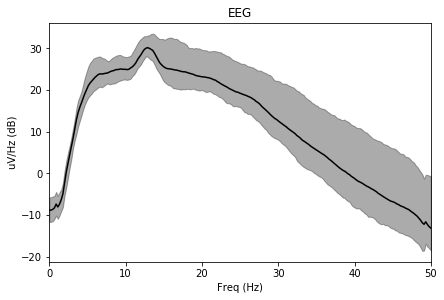

Figure(432x288)


In [7]:
print epochs.plot_psd(area_mode='range', tmax=4.499,fmax=50.)

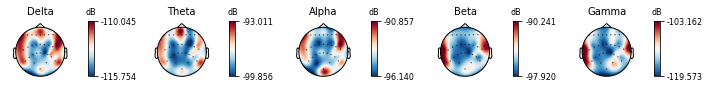

Figure(720x108)


In [8]:
print epochs.plot_psd_topomap()
picks = mne.pick_types(info=data.mne_info(), meg=False, eeg=True, misc=False)

In [9]:
mne.set_log_level(verbose = "ERROR")
# get test list
test_list = []
for i in range(0,data.num_tests):
    epochs_test = data.test_epochs(i)
    Y_test = epochs_test.events[:,-1]
    X_test = epochs_test.get_data()
    test_list.append({'Y_test':Y_test,'X_test':X_test})

In [10]:
import scipy.signal as spsig
def data_prep(data, sfreq, fmin, fmax):
    [b_high, a_high] = spsig.butter(4, float(fmin) / (sfreq / 2), 'high')
    [b_low, a_low] = spsig.butter(4, float(fmax) / (sfreq / 2), 'low')

    chunk_high = spsig.lfilter(b_high, a_high, data)
    chunk_low = spsig.lfilter(b_low, a_low, chunk_high)
    return chunk_low

## LDA Classifier

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from mne.decoding import CSP

Y_train = epochs.events[:,-1]
X_train = epochs.get_data()
X_train = data_prep(X_train, 1000, 6, 16)

# train classifier
svc = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg='ledoit_wolf', log=True)


X_train = csp.fit_transform(X_train, Y_train)
svc.fit(X_train, Y_train)

LDA_scores = []
for i in range(0, len(test_list)):
    X_test = data_prep(test_list[i]['X_test'], 1000, 6, 16)
    X_test = csp.transform(X_test)
    LDA_scores.append(svc.score(X_test, test_list[i]['Y_test']))

print "MAX:", np.max(LDA_scores)
print "MEAN:", np.mean(LDA_scores)
print "MIN:", np.min(LDA_scores)
print "DISP:", np.std(LDA_scores)

MAX: 1.0
MEAN: 0.802777777778
MIN: 0.566666666667
DISP: 0.129427752858


## Naive Bayes

In [12]:
from sklearn.naive_bayes import GaussianNB

Y_train = epochs.events[:,-1]
X_train = epochs.get_data()
X_train = data_prep(X_train, 1000, 6, 16)

# train classifier
svc = GaussianNB()
csp = CSP(n_components=4, reg='ledoit_wolf', log=True)


X_train = csp.fit_transform(X_train, Y_train)
svc.fit(X_train, Y_train)

Bayes_scores = []
for i in range(0, len(test_list)):
    X_test = data_prep(test_list[i]['X_test'], 1000, 6, 16)
    X_test = csp.transform(X_test)
    Bayes_scores.append(svc.score(X_test, test_list[i]['Y_test']))

print "MAX:", np.max(Bayes_scores)
print "MEAN:", np.mean(Bayes_scores)
print "MIN:", np.min(Bayes_scores)
print "DISP:", np.std(Bayes_scores)

MAX: 1.0
MEAN: 0.802777777778
MIN: 0.533333333333
DISP: 0.136394263302


## K-nearest neighbours

In [13]:
from sklearn.neighbors import KNeighborsClassifier

Y_train = epochs.events[:,-1]
X_train = epochs.get_data()
X_train = data_prep(X_train, 1000, 6, 16)

# train classifier
svc = KNeighborsClassifier()
csp = CSP(n_components=4, reg='ledoit_wolf', log=True)


X_train = csp.fit_transform(X_train, Y_train)
svc.fit(X_train, Y_train)

KNN_scores = []
for i in range(0, len(test_list)):
    X_test = data_prep(test_list[i]['X_test'], 1000, 6, 16)
    X_test = csp.transform(X_test)
    KNN_scores.append(svc.score(X_test, test_list[i]['Y_test']))

print "MAX:", np.max(KNN_scores)
print "MEAN:", np.mean(KNN_scores)
print "MIN:", np.min(KNN_scores)
print "DISP:", np.std(KNN_scores)

MAX: 0.966666666667
MEAN: 0.866666666667
MIN: 0.766666666667
DISP: 0.0561083607687


## Classification and Regression Trees

In [14]:
from sklearn.tree import DecisionTreeClassifier

Y_train = epochs.events[:,-1]
X_train = epochs.get_data()
X_train = data_prep(X_train, 1000, 6, 16)

# train classifier
svc = DecisionTreeClassifier()
csp = CSP(n_components=4, reg='ledoit_wolf', log=True)


X_train = csp.fit_transform(X_train, Y_train)
svc.fit(X_train, Y_train)

Trees_scores = []
for i in range(0, len(test_list)):
    X_test = data_prep(test_list[i]['X_test'], 1000, 6, 16)
    X_test = csp.transform(X_test)
    Trees_scores.append(svc.score(X_test, test_list[i]['Y_test']))

print "MAX:", np.max(Trees_scores)
print "MEAN:", np.mean(Trees_scores)
print "MIN:", np.min(Trees_scores)
print "DISP:", np.std(Trees_scores)

MAX: 0.933333333333
MEAN: 0.786111111111
MIN: 0.6
DISP: 0.0957024065386


## SVM (Support Vector Machines)

In [15]:
from sklearn.svm import SVC

Y_train = epochs.events[:,-1]
X_train = epochs.get_data()
X_train = data_prep(X_train, 1000, 6, 16)

# train classifier
svc = SVC()
csp = CSP(n_components=4, reg='ledoit_wolf', log=True)


X_train = csp.fit_transform(X_train, Y_train)
svc.fit(X_train, Y_train)

SVM_scores = []
for i in range(0, len(test_list)):
    X_test = data_prep(test_list[i]['X_test'], 1000, 6, 16)
    X_test = csp.transform(X_test)
    SVM_scores.append(svc.score(X_test, test_list[i]['Y_test']))

print "MAX:", np.max(SVM_scores)
print "MEAN:", np.mean(SVM_scores)
print "MIN:", np.min(SVM_scores)
print "DISP:", np.std(SVM_scores)

MAX: 1.0
MEAN: 0.844444444444
MIN: 0.666666666667
DISP: 0.109994388185


## Neural Network

In [21]:
from sklearn.neural_network import MLPClassifier

Y_train = epochs.events[:,-1]
X_train = epochs.get_data()
X_train = data_prep(X_train, 1000, 6, 16)

# train classifier
svc = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(8, 15), random_state=1)
csp = CSP(n_components=4, reg='ledoit_wolf', log=True)


X_train = csp.fit_transform(X_train, Y_train)
svc.fit(X_train, Y_train)

NN_scores = []
for i in range(0, len(test_list)):
    X_test = data_prep(test_list[i]['X_test'], 1000, 6, 16)
    X_test = csp.transform(X_test)
    NN_scores.append(svc.score(X_test, test_list[i]['Y_test']))

print "MAX:", np.max(NN_scores)
print "MEAN:", np.mean(NN_scores)
print "MIN:", np.min(NN_scores)
print "DISP:", np.std(NN_scores)

MAX: 0.933333333333
MEAN: 0.783333333333
MIN: 0.6
DISP: 0.102288625775


## Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression

Y_train = epochs.events[:,-1]
X_train = epochs.get_data()
X_train = data_prep(X_train, 1000, 6, 16)

# train classifier
svc = LogisticRegression()
csp = CSP(n_components=4, reg='ledoit_wolf', log=True)


X_train = csp.fit_transform(X_train, Y_train)
svc.fit(X_train, Y_train)

NN_scores = []
for i in range(0, len(test_list)):
    X_test = data_prep(test_list[i]['X_test'], 1000, 6, 16)
    X_test = csp.transform(X_test)
    NN_scores.append(svc.score(X_test, test_list[i]['Y_test']))

print "MAX:", np.max(NN_scores)
print "MEAN:", np.mean(NN_scores)
print "MIN:", np.min(NN_scores)
print "DISP:", np.std(NN_scores)

MAX: 0.966666666667
MEAN: 0.727777777778
MIN: 0.6
DISP: 0.112079116677


In [20]:
from skrvm import RVC

Y_train = epochs.events[:,-1]
X_train = epochs.get_data()
X_train = data_prep(X_train, 1000, 6, 16)

# train classifier
svc = RVC(alpha=1e-06, beta=1e-06, beta_fixed=False, bias_used=True, coef0=0.0,
coef1=None, degree=3, kernel='rbf', n_iter=3000, n_iter_posterior=50,
threshold_alpha=1000000000.0, tol=0.001, verbose=False)
csp = CSP(n_components=4, reg='ledoit_wolf', log=True)


X_train = csp.fit_transform(X_train, Y_train)
svc.fit(X_train, Y_train)

RVC_scores = []
for i in range(0, len(test_list)):
    X_test = data_prep(test_list[i]['X_test'], 1000, 6, 16)
    X_test = csp.transform(X_test)
    RVC_scores.append(svc.score(X_test, test_list[i]['Y_test']))

print "MAX:", np.max(NN_scores)
print "MEAN:", np.mean(NN_scores)
print "MIN:", np.min(NN_scores)
print "DISP:", np.std(NN_scores)

MAX: 0.966666666667
MEAN: 0.727777777778
MIN: 0.6
DISP: 0.112079116677
